In [1]:
import sys
!{sys.executable} -m pip install geopandas

In [2]:
import pandas as pd
import geopandas as gpd

In [3]:
POLL_DATA_PATH = "SUDO_data/pollDataCSV/aec_federal_election_tpp_by_polling_place_2019-8351572430875528240.csv"
EMPLOYMENT_INCOME_DATA_PATH = "SUDO_data/employmentIncomeCSV/gi_employ_inc_suburb_2011-1455394262157248157.csv"
POSTCODE_GEO_PATH = "geoJSON_boundaries/postcode/POA_2021_AUST_GDA2020_Small.json"
STATE_GEO_PATH = "geoJSON_boundaries/states/STE_2021_AUST_GDA2020_Simplified.json"
SUBURB_GEO_PATH = "geoJSON_boundaries/suburbs/SAL_2021_AUST_GDA94_Small.json"

# OUTPUT FILES
STATE_OUT_PATH = "geoJSON_data/state.json"
SUBURB_OUT_PATH = "geoJSON_data/suburb.json"
POSTCODE_OUT_PATH = "geoJSON_data/postcode.json"

Read SUDO data files and geoJSON files:

In [4]:
with open(POLL_DATA_PATH) as f:
    pollData = pd.read_csv(f)
    
with open(EMPLOYMENT_INCOME_DATA_PATH) as f:
    empIncData = pd.read_csv(f)

with open(POSTCODE_GEO_PATH) as f:
    postGeo = gpd.read_file(f)
    
with open(STATE_GEO_PATH) as f:
    stateGeo = gpd.read_file(f)

with open(SUBURB_GEO_PATH) as f:
    suburbGeo = gpd.read_file(f)

Set keys for locations:

In [5]:
POST_KEY = 'POA_NAME21'
STATE_KEY = 'STE_NAME21'
SUBURB_KEY_EMP_INC = 'ssc_name'
SUBURB_KEY_GEO = 'SAL_NAME21'

Fix column names:

In [6]:
colnames = {name: name.strip() for name in pollData.columns}
pollData.rename(columns=colnames, inplace=True)

colnames = {name: name.strip() for name in empIncData.columns}
empIncData.rename(columns=colnames, inplace=True)

Rename columns:

In [7]:
colnames = {'tpp_australian_labor_party_votes': 'labor_party_votes',
            'tpp_liberal_national_coalition_votes': 'liberal_national_coalition_votes'
           }
pollData.rename(columns=colnames, inplace=True)

colnames = {
    'emp_to_pop': 'employment%', 'cert': 'tafe%', 'female_par': 'female_participation', 
    'median11': 'median_income', 'male_less_': 'male_female_part_diff', 
    'male_part_': 'male_participation'
}
empIncData.rename(columns=colnames, inplace=True)

Fix missing values being assigned 0 (change to null):

In [8]:
import numpy as np
empIncData.replace(0, np.nan, inplace=True)

Convert SUDO dataframes to geo dataframes:

In [9]:
poll_gdf = gpd.GeoDataFrame(pollData, geometry=gpd.points_from_xy(pollData.longitude, pollData.latitude))

empInc_gdf = gpd.GeoDataFrame(empIncData)

Convert to matching CRS:

In [10]:
if poll_gdf.crs != stateGeo.crs:
    poll_gdf.set_crs(crs='EPSG:4283', inplace=True)
    poll_gdf.to_crs(crs=stateGeo.crs, inplace=True)

Join SUDO poll data with geo data:

In [11]:
postPoll_sjoin = gpd.sjoin(poll_gdf, postGeo, predicate="within")
statePoll_sjoin = gpd.sjoin(poll_gdf, stateGeo, predicate="within")
suburbPoll_sjoin = gpd.sjoin(poll_gdf, suburbGeo, predicate="within")

Compute election statistics for areas:

In [12]:
postPoll = postPoll_sjoin.dissolve(by=POST_KEY, 
                                  aggfunc={
                                      'total_formal_votes': 'sum',
                                      'labor_party_votes': 'sum',
                                      'liberal_national_coalition_votes': 'sum',
                                  }).reset_index()
postPoll = postGeo.merge(postPoll.drop('geometry', axis=1), on=POST_KEY, how='outer')
postPoll.drop(['AUS_CODE21', 'AUS_NAME21', 'AREASQKM21', 'LOCI_URI21', 'SHAPE_Leng', 'SHAPE_Area'], axis=1, inplace=True)

postPoll['labor%'] = postPoll.labor_party_votes/postPoll.total_formal_votes
postPoll['liberal_national%'] = postPoll.liberal_national_coalition_votes/postPoll.total_formal_votes


statePoll = statePoll_sjoin.dissolve(by=STATE_KEY,
                            aggfunc={
                                      'total_formal_votes': 'sum',
                                      'labor_party_votes': 'sum',
                                      'liberal_national_coalition_votes': 'sum',
                                  }).reset_index()
statePoll = stateGeo.merge(statePoll.drop('geometry', axis=1), on=STATE_KEY, how='outer')
statePoll.drop(['CHG_FLAG21', 'CHG_LBL21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21', 'LOCI_URI21'], axis=1, inplace=True)

statePoll['labor%'] = statePoll.labor_party_votes/statePoll.total_formal_votes
statePoll['liberal_national%'] = statePoll.liberal_national_coalition_votes/statePoll.total_formal_votes

suburbPoll = suburbPoll_sjoin.dissolve(by=SUBURB_KEY_GEO,
                            aggfunc={
                                      'total_formal_votes': 'sum',
                                      'labor_party_votes': 'sum',
                                      'liberal_national_coalition_votes': 'sum',
                                  }).reset_index()
suburbPoll = suburbGeo.merge(suburbPoll.drop('geometry', axis=1), on=SUBURB_KEY_GEO, how='outer')
suburbPoll.drop(['AUS_CODE21', 'AUS_NAME21', 'AREASQKM21', 'LOCI_URI21'], axis=1, inplace=True)

suburbPoll['labor%'] = suburbPoll.labor_party_votes/suburbPoll.total_formal_votes
suburbPoll['liberal_national%'] = suburbPoll.liberal_national_coalition_votes/suburbPoll.total_formal_votes

<AxesSubplot:>

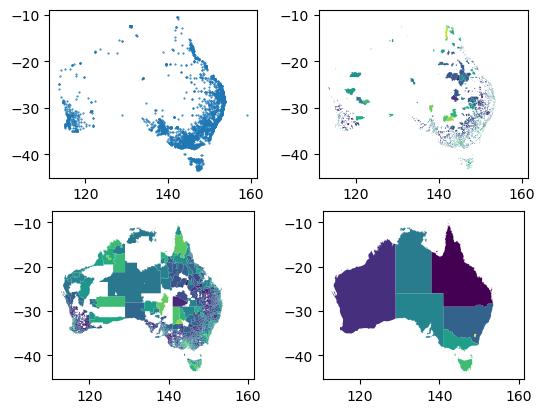

In [13]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2)

poll_gdf.plot(markersize=0.25, ax=axes[0,0])
suburbPoll.plot('labor%', ax=axes[0,1])
postPoll.plot('labor%', ax=axes[1,0])
statePoll.plot('labor%', ax=axes[1,1])

Change suburb column name such that keys can be used for merge:

In [14]:
empIncData.rename(columns={SUBURB_KEY_EMP_INC: SUBURB_KEY_GEO}, inplace=True)

Merge SUDO employment, income, and education data with suburb geoJSON and poll data:

In [15]:
suburbData = suburbPoll.merge(empIncData, on=SUBURB_KEY_GEO, how='outer')
suburbData = suburbData[suburbData['geometry'].notnull()] # Drop rows/suburbs without geometry

<AxesSubplot:>

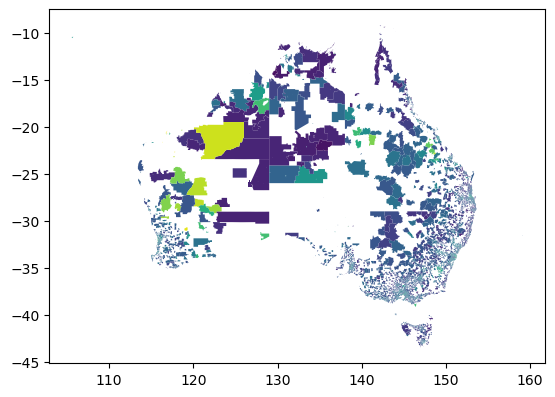

In [16]:
suburbData.plot('median_income')

Write to geoJSON:

In [19]:
statePoll.to_file(STATE_OUT_PATH, driver="GeoJSON")
postPoll.to_file(POSTCODE_OUT_PATH, driver="GeoJSON")
suburbData.to_file(SUBURB_OUT_PATH, driver="GeoJSON")